<a href="https://colab.research.google.com/github/Greta-gerasimov/PyT/blob/L3_optims/dl_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

у меня возникли трудности с данными Авито с каггла, поэтому я попыталась реализовать дз на датасете с домами

In [102]:
!pip install torchmetrics

In [103]:

import sklearn
import numpy as np
import pandas as pd

import torch.nn.functional as F

import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.optim import Adam, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import r2_score

import warnings
import math
warnings.filterwarnings('ignore')

In [104]:
train_dataset = sklearn.datasets.fetch_california_housing()
train_dataset

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [105]:
data = train_dataset.data
target = train_dataset.target

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=13)

In [107]:
# сделаем стандарт-скейлер так как это задача регрессии и мин-макс скейлер будет хуже работать

#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [108]:
class MyOwnCH(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_dataset = MyOwnCH(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = MyOwnCH(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [109]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=0)

In [110]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2 * hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2 * hidden_dim)
        self.fc2 = Perceptron(2 * hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [129]:
def model_comparing(model, optimizer):

    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []

    for epoch in range(200):

        model.train()

        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь) log RMSE
            eps = 1e-6

            loss = torch.sqrt(criterion(outputs.squeeze(), target) + eps)
            loss.backward()
            optimizer.step()



        model.eval()

        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()

        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_test = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()

    return r2_train_list, r2_test_list

In [130]:
def metrics_view(r2_train_list, r2_test_list, optim):

    epoch = np.arange(1,201,1)
    y_train = r2_train_list
    y_test = r2_test_list
    plt.plot(epoch, y_train, label='R2_train')
    plt.plot(epoch, y_test, label='R2_test')
    plt.title(f"{optim}")
    plt.ylabel('R2_score')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

SDG

In [131]:
model = FeedForward(8, 400)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.0)
r2_train_SGD, r2_test_SGD = model_comparing(model, optimizer)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

FeedForward(
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=8, out_features=800, bias=True)
  )
  (dp1): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (dp2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Perceptron(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
)
Epoch 1: r2_train = -1.6676268577575684, r2_test = -1.2168643474578857
Epoch 2: r2_train = -0.624397873878479, r2_test = -0.4164412021636963
Epoch 3: r2_train = -0.268100380897522, r2_test = -0.18861865997314453
Epoch 4: r2_train = -0.1329958438873291, r2_test = 0.02008211612701416
Epoch 5: r2_train = -0.06441259384155273, r2_test = 0.07025688886642456
Epoch 6: r2_train = -0

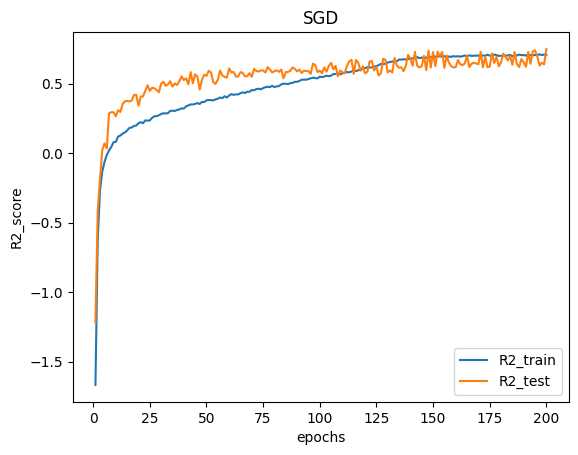

In [132]:
metrics_view(r2_train_SGD, r2_test_SGD, 'SGD')

Для RMS_prop & Adam беру 30 эпох, иначе происходит переучивание

In [115]:
def model_comparing(model, optimizer):

    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []

    for epoch in range(30):

        model.train()

        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь) log RMSE
            eps = 1e-6

            loss = torch.sqrt(criterion(outputs.squeeze(), target) + eps)
            loss.backward()
            optimizer.step()



        model.eval()

        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()

        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_test = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()

    return r2_train_list, r2_test_list

In [116]:
def metrics_view(r2_train_list, r2_test_list, optim):

    epoch = np.arange(1,31,1)
    y_train = r2_train_list
    y_test = r2_test_list
    plt.plot(epoch, y_train, label='R2_train')
    plt.plot(epoch, y_test, label='R2_test')
    plt.title(f"{optim}")
    plt.ylabel('R2_score')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()



RMS_PROP


In [117]:
model = FeedForward(8, 400)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
r2_train_RMSprop, r2_test_RMSprop = model_comparing(model, optimizer)

FeedForward(
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=8, out_features=800, bias=True)
  )
  (dp1): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (dp2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Perceptron(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
)
Epoch 1: r2_train = 0.219495952129364, r2_test = 0.562761664390564
Epoch 2: r2_train = 0.45290297269821167, r2_test = 0.6263526678085327
Epoch 3: r2_train = 0.5511770248413086, r2_test = 0.6097003221511841
Epoch 4: r2_train = 0.5934975147247314, r2_test = 0.6926482915878296
Epoch 5: r2_train = 0.6282854080200195, r2_test = 0.6970338821411133
Epoch 6: r2_train = 0.62880289554

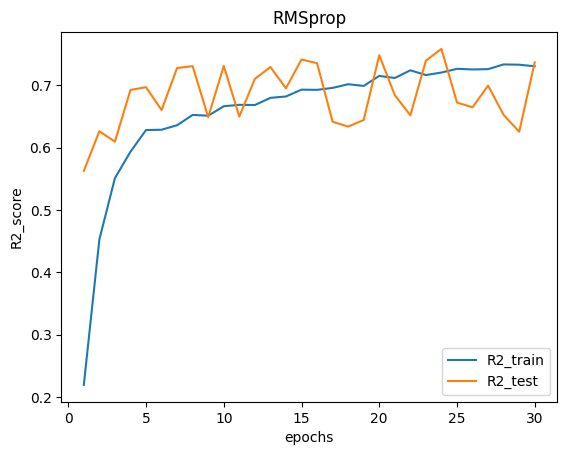

In [118]:
metrics_view(r2_train_RMSprop, r2_test_RMSprop, 'RMSprop')

Adam

In [119]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
r2_train_Adam, r2_test_Adam = model_comparing(model, optimizer)

Epoch 1: r2_train = 0.1262742280960083, r2_test = 0.49301862716674805
Epoch 2: r2_train = 0.40739476680755615, r2_test = 0.5815033912658691
Epoch 3: r2_train = 0.5360355377197266, r2_test = 0.5533239841461182
Epoch 4: r2_train = 0.5947792530059814, r2_test = 0.544237494468689
Epoch 5: r2_train = 0.623010516166687, r2_test = 0.6869124174118042
Epoch 6: r2_train = 0.639955461025238, r2_test = 0.6180956363677979
Epoch 7: r2_train = 0.6461686491966248, r2_test = 0.7063753008842468
Epoch 8: r2_train = 0.6610053777694702, r2_test = 0.6529668569564819
Epoch 9: r2_train = 0.6644257307052612, r2_test = 0.6094527244567871
Epoch 10: r2_train = 0.6747927665710449, r2_test = 0.7104008197784424
Epoch 11: r2_train = 0.6818166971206665, r2_test = 0.6467560529708862
Epoch 12: r2_train = 0.6816895604133606, r2_test = 0.6816613674163818
Epoch 13: r2_train = 0.6828573942184448, r2_test = 0.7441846132278442
Epoch 14: r2_train = 0.6987844705581665, r2_test = 0.6461995244026184
Epoch 15: r2_train = 0.7037843

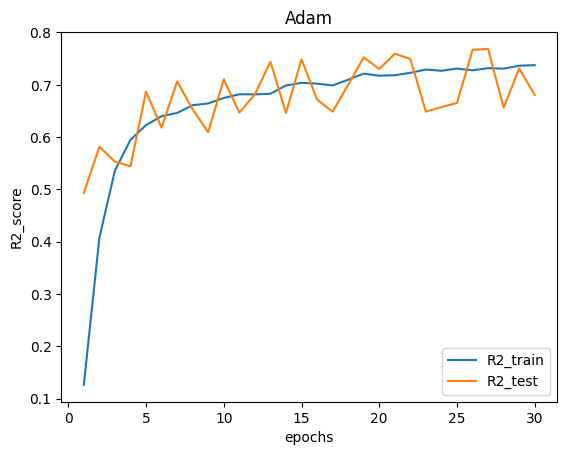

In [120]:
metrics_view(r2_train_Adam, r2_test_Adam, 'Adam')

Срвненеи метрик

In [133]:
metrics_result = pd.DataFrame([{'r2_train': r2_train_SGD[-1].item(), 'r2_test': r2_test_SGD[-1].item()},
                               {'r2_train': r2_train_RMSprop[-1].item(), 'r2_test': r2_test_RMSprop[-1].item()},
                               {'r2_train': r2_train_Adam[-1].item(), 'r2_test': r2_test_Adam[-1].item()},
                              ],
                              index = ['SGD', 'RMSprop', 'Adam'],
                              columns = ['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
SGD,0.705349,0.748955
RMSprop,0.730589,0.736901
Adam,0.737541,0.680439


Алгоримт SGD долго сходится - но достаточно стабильно. Ему требуется больше эпох, чтобы прийти к значениям метрик, которые достигаются другими алгоритмами значительно быстрее.

Алгоритмы Adam и RMSprop сходятся примерно одинаково. И быстрее чем SGD.